In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/Fold1/Train/"
val_dir = "/content/drive/MyDrive/Fold1/Val/"
test_dir = "/content/drive/MyDrive/Fold1/Test/"

In [ ]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [ ]:
import os

In [ ]:
def visualize_random_images(dataset_type="train", label_type="Others"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

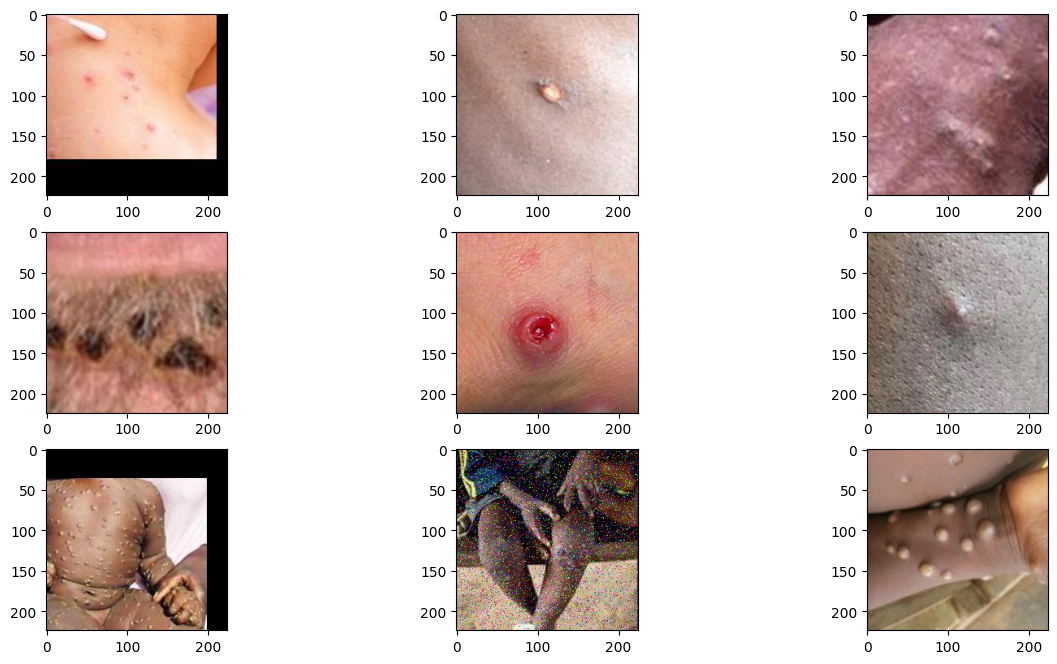

In [ ]:
visualize_random_images("train", "Monkeypox")

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.4)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
x = tf.keras.layers.BatchNormalization()(dense_1)
dropout_layer_2 = layers.Dropout(0.6)(x)
y = tf.keras.layers.BatchNormalization()(dropout_layer_2)
dense_2 = layers.Dense(128, activation="relu")(y)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_data,
                       epochs=20,
                       validation_data=val_data)

Epoch 1/20
67/67 [==============================] - 27s 192ms/step - loss: 0.2940 - accuracy: 0.8711 - val_loss: 0.8770 - val_accuracy: 0.8000
Epoch 2/20
67/67 [==============================] - 11s 155ms/step - loss: 0.1116 - accuracy: 0.9594 - val_loss: 0.5604 - val_accuracy: 0.8095
Epoch 3/20
67/67 [==============================] - 10s 150ms/step - loss: 0.0416 - accuracy: 0.9883 - val_loss: 0.5709 - val_accuracy: 0.8095
Epoch 4/20
67/67 [==============================] - 10s 149ms/step - loss: 0.0491 - accuracy: 0.9837 - val_loss: 0.8055 - val_accuracy: 0.8190
Epoch 5/20
67/67 [==============================] - 11s 152ms/step - loss: 0.0528 - accuracy: 0.9818 - val_loss: 0.7749 - val_accuracy: 0.7952
Epoch 6/20
67/67 [==============================] - 10s 151ms/step - loss: 0.0394 - accuracy: 0.9851 - val_loss: 0.4690 - val_accuracy: 0.8690
Epoch 7/20
67/67 [==============================] - 10s 146ms/step - loss: 0.0303 - accuracy: 0.9879 - val_loss: 0.6210 - val_accuracy: 0.8143

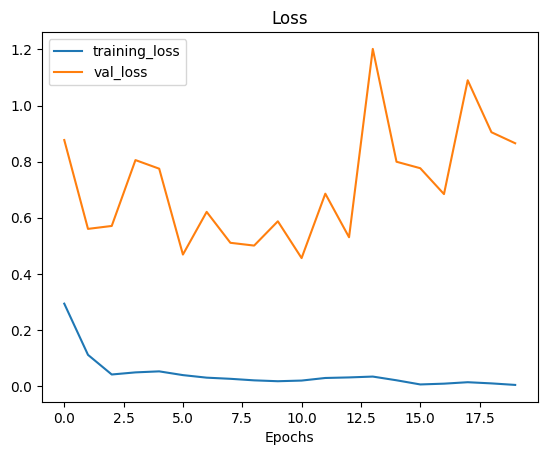

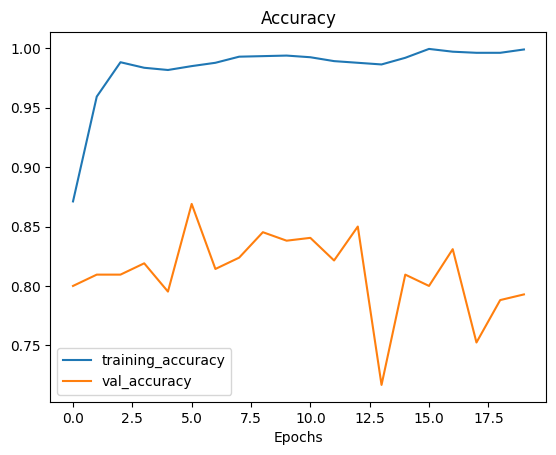

In [ ]:
plot_loss_curves(history)

In [ ]:
model.evaluate(test_data)

2/2 [==============================] - 0s 62ms/step - loss: 0.5274 - accuracy: 0.8667


[0.5273565649986267, 0.8666666746139526]

In [ ]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

2/2 [==============================] - 5s 135ms/step


In [ ]:
accuracy_score(y_true, y_pred)

0.8666666666666667

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.79      0.95      0.86        20
      Others       0.95      0.80      0.87        25

    accuracy                           0.87        45
   macro avg       0.87      0.88      0.87        45
weighted avg       0.88      0.87      0.87        45



<Axes: >

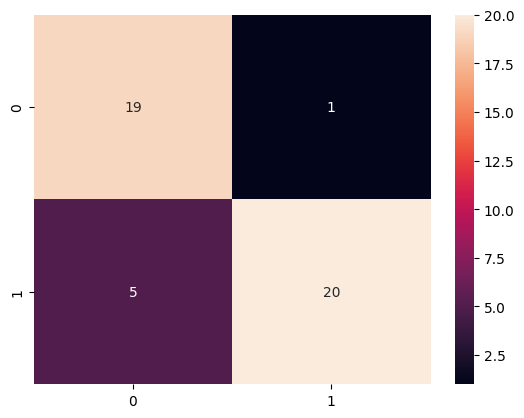

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True)

In [ ]:
model_list = []
for i in range(5):
  model = model
  model.fit(train_data,
                       epochs=20,
                       validation_data=val_data)
  model_list.append(model)

Epoch 1/20
67/67 [==============================] - 11s 152ms/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 1.2154 - val_accuracy: 0.7405
Epoch 2/20
67/67 [==============================] - 11s 152ms/step - loss: 0.0083 - accuracy: 0.9963 - val_loss: 1.1001 - val_accuracy: 0.7667
Epoch 3/20
67/67 [==============================] - 10s 148ms/step - loss: 0.0105 - accuracy: 0.9963 - val_loss: 0.9379 - val_accuracy: 0.7786
Epoch 4/20
67/67 [==============================] - 11s 151ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 1.1373 - val_accuracy: 0.7738
Epoch 5/20
67/67 [==============================] - 11s 153ms/step - loss: 0.0152 - accuracy: 0.9944 - val_loss: 0.6988 - val_accuracy: 0.8357
Epoch 6/20
67/67 [==============================] - 11s 165ms/step - loss: 0.0248 - accuracy: 0.9893 - val_loss: 1.2701 - val_accuracy: 0.7357
Epoch 7/20
67/67 [==============================] - 11s 154ms/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.9778 - val_accuracy: 0.7810

In [ ]:
import numpy as np
predictions = []
for model in model_list:
    predictions.append(model.predict(test_data))

# Combine the predictions of the N models to make a final prediction
final_prediction = np.mean(predictions, axis=0)

2/2 [==============================] - 0s 92ms/step


In [ ]:
y_pred = tf.math.round(final_prediction)
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.87      1.00      0.93        20
      Others       1.00      0.88      0.94        25

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45

